# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable" / "1y"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'timegan_lstm'

In [5]:
# Load real time series
data_train_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_1y.csv')
data_train_real_numpy = dc(data_train_real_df).to_numpy()

data_test_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_3mo.csv')
data_test_real_numpy = dc(data_test_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8747_12_5_timegan_lstm_16_2_20k_64.csv', shape=(8747, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8747_12_5_timegan_gru_24_2_10k_64.csv', shape=(8747, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8726_12_5_lstm_autoencoder.csv', shape=(8726, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'8759_12_5_fc_vae.csv', shape=(8759, 12, 5))

elif syn_data_type == 'jitter':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'jittered_01.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_train_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal train data:\n')
print(data_train_real_df.describe())

print('\n\nreal test data:\n')
print(data_test_real_df.describe())



 syn data:

       traffic_volume           temp        rain_1h        snow_1h  \
count   104964.000000  104964.000000  104964.000000  104964.000000   
mean      3110.944216     282.134022       0.036676       0.000156   
std       1928.981595      11.968117       0.143883       0.000477   
min         50.628945     249.730619       0.000003       0.000000   
25%       1229.601124     271.711338       0.000453       0.000000   
50%       3169.789237     281.234170       0.001995       0.000001   
75%       4905.010753     293.498541       0.009782       0.000111   
max       7066.810412     303.700879       4.466873       0.011250   

          clouds_all  
count  104964.000000  
mean       47.137230  
std        39.115225  
min         0.011721  
25%         2.917495  
50%        55.389917  
75%        87.674758  
max        96.796656  


real train data:

       traffic_volume         temp      rain_1h      snow_1h   clouds_all
count     8759.000000  8759.000000  8759.000000  8759.

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 12,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 500,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(
    data_train_real=data_train_real_numpy, 
    data_test_real=data_test_real_numpy,
    data_syn=data_syn_numpy, 
    hyperparameters=hyperparameters, 
    include_baseline=True, 
    verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  12
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  500
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.21555846293259712 // Train Acc: 0.011405109489051095
Val Loss: 0.14593363145147176 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02474954461230196 // Train Acc: 0.011405109489051095
Val Loss: 0.026075016816749293 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012587684081751772 // Train Acc: 0.011405109489051095
Val Loss: 0.013803024180507398 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01040902143271205 // Train Acc: 0.011405109489051095
Val Loss: 0.011090150339227608 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00905232136962038 // Train Acc: 0.011405109489051095
Val Loss: 0.009486339695286006 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008148245108534792 // Train Acc: 0.011405109489051095
Val Loss: 0.00869554135373191 // Val Acc: 0.0
**

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:24<30:38, 204.25s/it]

Epoch: 1
Train Loss: 0.2106305353792153 // Train Acc: 0.011405109489051095
Val Loss: 0.15997338493573754 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02936526698257475 // Train Acc: 0.011405109489051095
Val Loss: 0.03120576297206914 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012851943400430147 // Train Acc: 0.011405109489051095
Val Loss: 0.014114130617064588 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010763298320740352 // Train Acc: 0.011405109489051095
Val Loss: 0.011614971506573698 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009311052610295533 // Train Acc: 0.011405109489051095
Val Loss: 0.009627736204385976 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008097956201357318 // Train Acc: 0.011405109489051095
Val Loss: 0.008327655439429423 // Val Acc: 0.0
*

 20%|██        | 2/10 [06:47<27:11, 203.89s/it]

Epoch: 1
Train Loss: 0.12331428089906482 // Train Acc: 0.011405109489051095
Val Loss: 0.09391133722794406 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01812124420909116 // Train Acc: 0.011405109489051095
Val Loss: 0.020149814252577284 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012227586655789158 // Train Acc: 0.011405109489051095
Val Loss: 0.0135941421989735 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010083496407010884 // Train Acc: 0.011405109489051095
Val Loss: 0.01091933306238121 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00865705265751938 // Train Acc: 0.011405109489051095
Val Loss: 0.009238464867367464 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007977782192905127 // Train Acc: 0.011405109489051095
Val Loss: 0.008541468106319798 // Val Acc: 0.0
***

 30%|███       | 3/10 [10:11<23:46, 203.81s/it]

Epoch: 1
Train Loss: 0.11838397510812013 // Train Acc: 0.011405109489051095
Val Loss: 0.0962708400671973 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.028472720400641 // Train Acc: 0.011405109489051095
Val Loss: 0.030907829894739038 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012860618336262168 // Train Acc: 0.011405109489051095
Val Loss: 0.01438419777653454 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009581494484569224 // Train Acc: 0.011405109489051095
Val Loss: 0.010465464232872953 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008357177478308877 // Train Acc: 0.011405109489051095
Val Loss: 0.009308027363765766 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007951723306310655 // Train Acc: 0.011405109489051095
Val Loss: 0.008665995884631924 // Val Acc: 0.0
***

 40%|████      | 4/10 [13:37<20:28, 204.75s/it]

Epoch: 1
Train Loss: 0.16296303107056523 // Train Acc: 0.011405109489051095
Val Loss: 0.11971092032378211 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02127275432725131 // Train Acc: 0.011405109489051095
Val Loss: 0.022253871703629986 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012126354995628913 // Train Acc: 0.011405109489051095
Val Loss: 0.013251798398628393 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010526764974334569 // Train Acc: 0.011405109489051095
Val Loss: 0.011460011797573636 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009780062386344601 // Train Acc: 0.011405109489051095
Val Loss: 0.01057633537771728 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009241872546976827 // Train Acc: 0.011405109489051095
Val Loss: 0.009908608677933979 // Val Acc: 0.0


 50%|█████     | 5/10 [17:02<17:03, 204.77s/it]

Epoch: 1
Train Loss: 0.12149234238440973 // Train Acc: 0.011405109489051095
Val Loss: 0.09856909595649033 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.022807595736421916 // Train Acc: 0.011405109489051095
Val Loss: 0.0248127982896917 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01257374660064378 // Train Acc: 0.011405109489051095
Val Loss: 0.0140437494881232 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00976534683366109 // Train Acc: 0.011405109489051095
Val Loss: 0.010525160705369404 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008391995624516731 // Train Acc: 0.011405109489051095
Val Loss: 0.009109479436815223 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007881658889326083 // Train Acc: 0.011405109489051095
Val Loss: 0.008600559065063648 // Val Acc: 0.0
****

 60%|██████    | 6/10 [20:27<13:38, 204.69s/it]

Epoch: 1
Train Loss: 0.15406323422467078 // Train Acc: 0.011405109489051095
Val Loss: 0.12632203345899196 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.024618909281277416 // Train Acc: 0.011405109489051095
Val Loss: 0.026249097413657344 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011562823211301771 // Train Acc: 0.011405109489051095
Val Loss: 0.012869467876632424 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009087261070844031 // Train Acc: 0.011405109489051095
Val Loss: 0.010244679452358362 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008300792631934513 // Train Acc: 0.011405109489051095
Val Loss: 0.009134983548017986 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007939735238855012 // Train Acc: 0.011405109489051095
Val Loss: 0.008424602387308636 // Val Acc: 0.

 70%|███████   | 7/10 [21:44<08:08, 162.92s/it]

INFO: Validation loss did not improve in epoch 188
Early stopping after 188 epochs
Epoch: 1
Train Loss: 0.30348900529168493 // Train Acc: 0.0
Val Loss: 0.23708742922719786 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.021135747772607492 // Train Acc: 0.011405109489051095
Val Loss: 0.024185406954904252 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013268702593801992 // Train Acc: 0.011405109489051095
Val Loss: 0.014788818336776732 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009450276427728933 // Train Acc: 0.011405109489051095
Val Loss: 0.010720096278579576 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008210104030011439 // Train Acc: 0.011405109489051095
Val Loss: 0.009213049759102218 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0074766887652256055 // Train Acc:

 80%|████████  | 8/10 [25:09<05:52, 176.35s/it]

Epoch: 1
Train Loss: 0.2317183439375112 // Train Acc: 0.011405109489051095
Val Loss: 0.15795652164481855 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.028883478862580157 // Train Acc: 0.011405109489051095
Val Loss: 0.031803494456278926 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014356408382929101 // Train Acc: 0.011405109489051095
Val Loss: 0.016470336190917912 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010817289807881316 // Train Acc: 0.011405109489051095
Val Loss: 0.011822541531942347 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010204759378404269 // Train Acc: 0.011405109489051095
Val Loss: 0.010896596205009915 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009712079146887128 // Train Acc: 0.011405109489051095
Val Loss: 0.010252514182973434 // Val Acc: 0.0

 90%|█████████ | 9/10 [28:34<03:05, 185.28s/it]

Epoch: 1
Train Loss: 0.19769808091903038 // Train Acc: 0.011405109489051095
Val Loss: 0.13092892316062182 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.027086167976967175 // Train Acc: 0.011405109489051095
Val Loss: 0.029794649796231705 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012018089250229761 // Train Acc: 0.011405109489051095
Val Loss: 0.013198044959127027 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009687577804251418 // Train Acc: 0.011405109489051095
Val Loss: 0.010337430199690382 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008238998165245365 // Train Acc: 0.011405109489051095
Val Loss: 0.008740089635145576 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007676079407008025 // Train Acc: 0.011405109489051095
Val Loss: 0.008153153282097158 // Val Acc: 0.

100%|██████████| 10/10 [31:58<00:00, 191.89s/it]


Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (1741, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.27272338707629407 // Train Acc: 0.0
Val Loss: 0.17556095008145678 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03367755992006358 // Train Acc: 0.014269406392694063
Val Loss: 0.02775507511740381 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016640718882801393 // Train Acc: 0.014269406392694063
Val Loss: 0.01457369527356191 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012084171561881492 // Train Acc: 0.014269406392694063
Val Loss: 0.010461340340870347 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009602066365466134 // Train Acc: 0.014269406392694063
Val Loss: 0.008324722619727254 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008559666714071802 // Train Acc: 0.014269406392694063
Val Loss: 0.007202315436337482 // Val Acc: 0.0
******************

 10%|█         | 1/10 [02:47<25:08, 167.56s/it]

Epoch: 1
Train Loss: 0.1567900315964739 // Train Acc: 0.014269406392694063
Val Loss: 0.09343612365085971 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03509601045689082 // Train Acc: 0.014269406392694063
Val Loss: 0.02968331194398078 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014858061202151114 // Train Acc: 0.014269406392694063
Val Loss: 0.012004976435987786 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011222131684800976 // Train Acc: 0.014269406392694063
Val Loss: 0.008955459694632075 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010211914381199436 // Train Acc: 0.014269406392694063
Val Loss: 0.008098805162378334 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009476068554037851 // Train Acc: 0.014269406392694063
Val Loss: 0.0074988471217114815 // Val Acc: 0.0


 20%|██        | 2/10 [05:34<22:16, 167.01s/it]

Epoch: 1
Train Loss: 0.3456444311036503 // Train Acc: 0.0
Val Loss: 0.2366648155857216 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04394809877899684 // Train Acc: 0.014269406392694063
Val Loss: 0.03781111372465437 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015812011814110627 // Train Acc: 0.014269406392694063
Val Loss: 0.014682470659979366 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012710352454836305 // Train Acc: 0.014269406392694063
Val Loss: 0.011507452482526952 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.01163150805854515 // Train Acc: 0.014269406392694063
Val Loss: 0.01036921653642573 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.010756569498295144 // Train Acc: 0.014269406392694063
Val Loss: 0.009515573960644277 // Val Acc: 0.0
*********************

 30%|███       | 3/10 [08:20<19:27, 166.81s/it]

Epoch: 1
Train Loss: 0.2917548299312047 // Train Acc: 0.0
Val Loss: 0.18908558562397956 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04740195875332508 // Train Acc: 0.014269406392694063
Val Loss: 0.041125504537062214 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.018196062450658648 // Train Acc: 0.014269406392694063
Val Loss: 0.014706010185182094 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012052478049201338 // Train Acc: 0.014269406392694063
Val Loss: 0.009628003120253031 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010733404337666657 // Train Acc: 0.014269406392694063
Val Loss: 0.008571408955718984 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009822480145046598 // Train Acc: 0.014269406392694063
Val Loss: 0.007858091779053212 // Val Acc: 0.0
*****************

 40%|████      | 4/10 [08:55<11:27, 114.61s/it]

INFO: Validation loss did not improve in epoch 104
Early stopping after 104 epochs
Epoch: 1
Train Loss: 0.1848711857240494 // Train Acc: 0.014269406392694063
Val Loss: 0.1215701395815069 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04150673888249484 // Train Acc: 0.014269406392694063
Val Loss: 0.03576792292296886 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.0155573142410711 // Train Acc: 0.014269406392694063
Val Loss: 0.013311403807760639 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011199215319662538 // Train Acc: 0.014269406392694063
Val Loss: 0.009355853823944927 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009406843134435957 // Train Acc: 0.014269406392694063
Val Loss: 0.007825450501828032 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008691771344768657 // 

 50%|█████     | 5/10 [11:42<11:07, 133.48s/it]

Epoch: 1
Train Loss: 0.32289856583832605 // Train Acc: 0.028538812785388126
Val Loss: 0.21120131733742628 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03721921951361171 // Train Acc: 0.014269406392694063
Val Loss: 0.031948881562460556 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01612974276774686 // Train Acc: 0.014269406392694063
Val Loss: 0.013075359622863205 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011640802995922664 // Train Acc: 0.014269406392694063
Val Loss: 0.009125464028594168 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010378423468507486 // Train Acc: 0.014269406392694063
Val Loss: 0.0081026059279049 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009595805182138704 // Train Acc: 0.014269406392694063
Val Loss: 0.0075245469512248584 // Val Acc: 0.0
*

 60%|██████    | 6/10 [14:29<09:39, 144.81s/it]

Epoch: 1
Train Loss: 0.14939253690512214 // Train Acc: 0.014269406392694063
Val Loss: 0.09770362265408039 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03438310340029872 // Train Acc: 0.014269406392694063
Val Loss: 0.02949458441951058 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014088235821545158 // Train Acc: 0.014269406392694063
Val Loss: 0.012518096368082545 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010970023894984462 // Train Acc: 0.014269406392694063
Val Loss: 0.009263178536837752 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009399834213104337 // Train Acc: 0.014269406392694063
Val Loss: 0.007772202032025565 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00826444589085324 // Train Acc: 0.014269406392694063
Val Loss: 0.006629306217655539 // Val Acc: 0.0
*

 70%|███████   | 7/10 [17:15<07:35, 151.92s/it]

Epoch: 1
Train Loss: 0.14091808655082363 // Train Acc: 0.014269406392694063
Val Loss: 0.09417679252272303 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03336956408980502 // Train Acc: 0.014269406392694063
Val Loss: 0.028979781608689914 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014677639518009678 // Train Acc: 0.014269406392694063
Val Loss: 0.012906982885165648 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011942387120500548 // Train Acc: 0.014269406392694063
Val Loss: 0.009897871239280159 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010415762278025962 // Train Acc: 0.014269406392694063
Val Loss: 0.008532567411153155 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009392924188980705 // Train Acc: 0.014269406392694063
Val Loss: 0.007713258719410409 // Val Acc: 0.0

 80%|████████  | 8/10 [20:02<05:13, 156.61s/it]

Epoch: 1
Train Loss: 0.20762240987049935 // Train Acc: 0.014269406392694063
Val Loss: 0.14240479325367647 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03604315476891793 // Train Acc: 0.014269406392694063
Val Loss: 0.030454201911660757 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015744474971641418 // Train Acc: 0.014269406392694063
Val Loss: 0.012907876781272616 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011567055471517894 // Train Acc: 0.014269406392694063
Val Loss: 0.009182979517870329 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00959210871712445 // Train Acc: 0.014269406392694063
Val Loss: 0.007676245373758403 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008577480469405072 // Train Acc: 0.014269406392694063
Val Loss: 0.006938340324400501 // Val Acc: 0.0


 90%|█████████ | 9/10 [22:48<02:39, 159.76s/it]

Epoch: 1
Train Loss: 0.33517186743415656 // Train Acc: 0.028538812785388126
Val Loss: 0.21719968115741556 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03878067284567307 // Train Acc: 0.014269406392694063
Val Loss: 0.03341870456933975 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015872099405988098 // Train Acc: 0.014269406392694063
Val Loss: 0.014613095958801833 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012253026110672957 // Train Acc: 0.014269406392694063
Val Loss: 0.010936901455914432 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010233410481537893 // Train Acc: 0.014269406392694063
Val Loss: 0.009159349811009385 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009305947684028003 // Train Acc: 0.014269406392694063
Val Loss: 0.008301508634097197 // Val Acc: 0.0


100%|██████████| 10/10 [25:35<00:00, 153.52s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.32670760590191844 // Train Acc: 0.014269406392694063
Val Loss: 0.2363598815419457 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04325915116935832 // Train Acc: 0.0
Val Loss: 0.04214474497870965 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.02828059490072673 // Train Acc: 0.0
Val Loss: 0.027621111730960282 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.023842226947789594 // Train Acc: 0.0
Val Loss: 0.0231267933818427 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.02040040548295463 // Train Acc: 0.0
Val Loss: 0.019937304940752007 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.018659351780568354 // Train Acc: 0.0
Val Loss: 0.01862321247939359 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0177232316720669

 10%|█         | 1/10 [02:48<25:19, 168.86s/it]

Epoch: 1
Train Loss: 0.17288598894528603 // Train Acc: 0.0
Val Loss: 0.11798332252285697 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.037185868920256555 // Train Acc: 0.0
Val Loss: 0.035885822942311116 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.027017165753633193 // Train Acc: 0.0
Val Loss: 0.02637242559682239 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.024115233250455632 // Train Acc: 0.0
Val Loss: 0.02343853529204022 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.02103155695080553 // Train Acc: 0.0
Val Loss: 0.02056284774602814 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.01898471859483618 // Train Acc: 0.0
Val Loss: 0.018937837180088866 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.018296845574102036 // Train Ac

 20%|██        | 2/10 [05:34<22:16, 167.04s/it]

Epoch: 1
Train Loss: 0.13210575786083256 // Train Acc: 0.0
Val Loss: 0.10499191433191299 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.036780479623506605 // Train Acc: 0.0
Val Loss: 0.035446928238326854 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.026461269655456282 // Train Acc: 0.0
Val Loss: 0.02583132264288989 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.02368920901152369 // Train Acc: 0.0
Val Loss: 0.02295845567502759 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0206566292656475 // Train Acc: 0.0
Val Loss: 0.020098753519017586 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.018912611339989727 // Train Acc: 0.0
Val Loss: 0.018937982584942472 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.018419245517383154 // Train Ac

 30%|███       | 3/10 [08:20<19:25, 166.50s/it]

Epoch: 1
Train Loss: 0.11903889055393602 // Train Acc: 0.0
Val Loss: 0.0910156327215108 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.033252080974751685 // Train Acc: 0.0
Val Loss: 0.032326810773123396 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.025959153865893547 // Train Acc: 0.0
Val Loss: 0.025292859802191908 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0219745702539745 // Train Acc: 0.0
Val Loss: 0.021457441862333903 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.019449948996611652 // Train Acc: 0.0
Val Loss: 0.019440184093334457 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.018516694950407635 // Train Acc: 0.0
Val Loss: 0.018752033669840205 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.01797993207716098 // Train A

 40%|████      | 4/10 [11:06<16:38, 166.34s/it]

Epoch: 1
Train Loss: 0.13152733836408076 // Train Acc: 0.0
Val Loss: 0.10004269934513352 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03556404794783217 // Train Acc: 0.0
Val Loss: 0.03416333875872872 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.025269245779881738 // Train Acc: 0.0
Val Loss: 0.02473779588260434 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.022467132736439712 // Train Acc: 0.0
Val Loss: 0.02193467415530573 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.020314095754465557 // Train Acc: 0.0
Val Loss: 0.019969506019895725 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.01902607784576748 // Train Acc: 0.0
Val Loss: 0.01893368223682046 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.0182939998010284 // Train Acc: 

 50%|█████     | 5/10 [13:52<13:50, 166.10s/it]

Epoch: 1
Train Loss: 0.18390936605190034 // Train Acc: 0.0
Val Loss: 0.13825847384604542 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.039317933451299254 // Train Acc: 0.0
Val Loss: 0.037840592454780234 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.026513347874255213 // Train Acc: 0.0
Val Loss: 0.026002757539126006 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.024335235127643365 // Train Acc: 0.0
Val Loss: 0.02376869684931907 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.022744584014239514 // Train Acc: 0.0
Val Loss: 0.02220104416324334 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.021338369012661448 // Train Acc: 0.0
Val Loss: 0.02086347205225717 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.02020412656908098 // Train A

 60%|██████    | 6/10 [16:38<11:04, 166.08s/it]

Epoch: 1
Train Loss: 0.4314349252883702 // Train Acc: 0.014269406392694063
Val Loss: 0.34532473927194424 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03914589206922 // Train Acc: 0.0
Val Loss: 0.03806818318976597 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.026596376629860977 // Train Acc: 0.0
Val Loss: 0.026118547994304787 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.024006240142160625 // Train Acc: 0.0
Val Loss: 0.023501371626149525 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.021840331102104763 // Train Acc: 0.0
Val Loss: 0.021396936916492203 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.01981177267546183 // Train Acc: 0.0
Val Loss: 0.019637333406982097 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.018464296222685

 70%|███████   | 7/10 [19:24<08:18, 166.07s/it]

Epoch: 1
Train Loss: 0.16395026214046565 // Train Acc: 0.0
Val Loss: 0.1289422264153307 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.034452808038522936 // Train Acc: 0.0
Val Loss: 0.032959895699538964 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.025747164154688924 // Train Acc: 0.0
Val Loss: 0.025220652771267026 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.024037996868360532 // Train Acc: 0.0
Val Loss: 0.023513402671299196 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.022603239594069926 // Train Acc: 0.0
Val Loss: 0.022129656865515494 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.021190461577192697 // Train Acc: 0.0
Val Loss: 0.020806994145228103 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.02015912455196182 // Train

 80%|████████  | 8/10 [22:10<05:32, 166.01s/it]

Epoch: 1
Train Loss: 0.3159210988103527 // Train Acc: 0.014269406392694063
Val Loss: 0.22948573340069164 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03802323948642979 // Train Acc: 0.0
Val Loss: 0.03659805425188758 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.025909153651020842 // Train Acc: 0.0
Val Loss: 0.025406873124566944 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.02361602160110049 // Train Acc: 0.0
Val Loss: 0.023051565817811273 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0211444620476806 // Train Acc: 0.0
Val Loss: 0.020668234455991873 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.018803945761684277 // Train Acc: 0.0
Val Loss: 0.01866423167626966 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.017844092628182

 90%|█████████ | 9/10 [24:56<02:46, 166.06s/it]

Epoch: 1
Train Loss: 0.1691258841929915 // Train Acc: 0.0
Val Loss: 0.133287783508951 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03918053754966825 // Train Acc: 0.0
Val Loss: 0.03763263506645506 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.025713694709263844 // Train Acc: 0.0
Val Loss: 0.025144055621190504 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.02226396448076724 // Train Acc: 0.0
Val Loss: 0.021699795457111162 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.019468344826693542 // Train Acc: 0.0
Val Loss: 0.019333617414601826 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.018458257971510086 // Train Acc: 0.0
Val Loss: 0.018557474652135916 // Val Acc: 0.0
**************************************************
Epoch: 61
Train Loss: 0.01782721497934975 // Train Acc:

100%|██████████| 10/10 [27:42<00:00, 166.25s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.09735318772167893 // Train Acc: 0.005712979890310786
Val Loss: 0.07183713153662051 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01867873889395807 // Train Acc: 0.005712979890310786
Val Loss: 0.014317738419563016 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01544338252252373 // Train Acc: 0.005712979890310786
Val Loss: 0.011163595940589029 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.014200483031666256 // Train Acc: 0.005712979890310786
Val Loss: 0.010343768606510232 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.01366499888538715 // Train Acc: 0.005712979890310786
Val Loss: 0.010134095038451692 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.013324881263223683 // Train Acc: 0.005712979890310786
Val Loss: 0.009945345919250566 // Val Acc: 0.0
*

 10%|█         | 1/10 [01:24<12:37, 84.14s/it]

INFO: Validation loss did not improve in epoch 107
Early stopping after 107 epochs
Epoch: 1
Train Loss: 0.13600726080190056 // Train Acc: 0.005712979890310786
Val Loss: 0.07829237603308524 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.018521672402469398 // Train Acc: 0.005712979890310786
Val Loss: 0.014351110809537418 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01623449603587702 // Train Acc: 0.005712979890310786
Val Loss: 0.012006960802382845 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.014898859359446565 // Train Acc: 0.005712979890310786
Val Loss: 0.010959919165436397 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.014431579832338354 // Train Acc: 0.005712979890310786
Val Loss: 0.0105097933590193 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.014103138560541587 

 20%|██        | 2/10 [07:58<35:35, 266.90s/it]

Epoch: 1
Train Loss: 0.12747127647210302 // Train Acc: 0.005712979890310786
Val Loss: 0.07668702874113531 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.019450813448022526 // Train Acc: 0.005712979890310786
Val Loss: 0.016126024646355826 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015600725422720587 // Train Acc: 0.005712979890310786
Val Loss: 0.011425501235541613 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.014552984736566951 // Train Acc: 0.005712979890310786
Val Loss: 0.010700367514372748 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.013678969482514987 // Train Acc: 0.005712979890310786
Val Loss: 0.01024304689182078 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.012914539981161804 // Train Acc: 0.005712979890310786
Val Loss: 0.009846154216896085 // Val Acc: 0.0

 30%|███       | 3/10 [13:47<35:29, 304.23s/it]

INFO: Validation loss did not improve in epoch 442
Early stopping after 442 epochs
Epoch: 1
Train Loss: 0.12230823028635172 // Train Acc: 0.005712979890310786
Val Loss: 0.06878088710500914 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.018881589242374656 // Train Acc: 0.005712979890310786
Val Loss: 0.015485018991646083 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016746824850512147 // Train Acc: 0.005712979890310786
Val Loss: 0.01242850614054238 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.015173030658361163 // Train Acc: 0.005712979890310786
Val Loss: 0.0109013540273094 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.01430244604551269 // Train Acc: 0.005712979890310786
Val Loss: 0.010610062156475204 // Val Acc: 0.0
**************************************************
INFO: Validation loss did not improve in epo

 40%|████      | 4/10 [14:26<19:56, 199.40s/it]

INFO: Validation loss did not improve in epoch 49
Early stopping after 49 epochs
Epoch: 1
Train Loss: 0.14021258564900874 // Train Acc: 0.005712979890310786
Val Loss: 0.0758092466960935 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01875062743661554 // Train Acc: 0.005712979890310786
Val Loss: 0.0153099549934268 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015607262507823365 // Train Acc: 0.005712979890310786
Val Loss: 0.011506928562405793 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.014758436618393229 // Train Acc: 0.005712979890310786
Val Loss: 0.010681359316496289 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.014009878375623681 // Train Acc: 0.005712979890310786
Val Loss: 0.010426125598742682 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.013492426999939956 // 

 50%|█████     | 5/10 [18:39<18:13, 218.71s/it]

INFO: Validation loss did not improve in epoch 321
Early stopping after 321 epochs
Epoch: 1
Train Loss: 0.2899841418867791 // Train Acc: 0.011425959780621572
Val Loss: 0.11230660481926273 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02114693403041409 // Train Acc: 0.005712979890310786
Val Loss: 0.017982327612116933 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01575610814513928 // Train Acc: 0.005712979890310786
Val Loss: 0.011903794975403477 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.014453839932498564 // Train Acc: 0.005712979890310786
Val Loss: 0.01064603160108056 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.013565467118491612 // Train Acc: 0.005712979890310786
Val Loss: 0.010062628685880233 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.012911460348753977 /

 60%|██████    | 6/10 [25:13<18:32, 278.23s/it]

Epoch: 1
Train Loss: 0.1915015218714746 // Train Acc: 0.0
Val Loss: 0.08659922079566647 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01945889007489127 // Train Acc: 0.005712979890310786
Val Loss: 0.015164661159574547 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.017236099766151914 // Train Acc: 0.005712979890310786
Val Loss: 0.01266552579780931 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.016225542108250793 // Train Acc: 0.005712979890310786
Val Loss: 0.01169597388327341 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.015273326048474261 // Train Acc: 0.005712979890310786
Val Loss: 0.010999935610658106 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.014731472476438315 // Train Acc: 0.005712979890310786
Val Loss: 0.01058672504116069 // Val Acc: 0.0
********************

 70%|███████   | 7/10 [31:45<15:47, 315.71s/it]

Epoch: 1
Train Loss: 0.18223632878574528 // Train Acc: 0.0
Val Loss: 0.07889716568238594 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01901059467141164 // Train Acc: 0.005712979890310786
Val Loss: 0.015033487798920012 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016294578251205862 // Train Acc: 0.005712979890310786
Val Loss: 0.011921290814986123 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.014738337205334734 // Train Acc: 0.005712979890310786
Val Loss: 0.01046939825584345 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.014188112129399407 // Train Acc: 0.005712979890310786
Val Loss: 0.010203837807399823 // Val Acc: 0.0
**************************************************
INFO: Validation loss did not improve in epoch 51
Epoch: 51
Train Loss: 0.013595091356935023 // Train Acc: 0.005712979890310786
Val Loss: 0.01

 80%|████████  | 8/10 [32:29<07:37, 228.95s/it]

INFO: Validation loss did not improve in epoch 55
Early stopping after 55 epochs
Epoch: 1
Train Loss: 0.17436547956380047 // Train Acc: 0.005712979890310786
Val Loss: 0.08541101688409553 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.019096430905258633 // Train Acc: 0.005712979890310786
Val Loss: 0.01557824160109329 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01535014877984576 // Train Acc: 0.005712979890310786
Val Loss: 0.011280078201226014 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.014658349096669493 // Train Acc: 0.005712979890310786
Val Loss: 0.010351403260274845 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.013966780145255887 // Train Acc: 0.005712979890310786
Val Loss: 0.009987591396031134 // Val Acc: 0.0
**************************************************
INFO: Validation loss did not improve in epo

 90%|█████████ | 9/10 [33:07<02:49, 169.23s/it]

INFO: Validation loss did not improve in epoch 48
Early stopping after 48 epochs
Epoch: 1
Train Loss: 0.19043629964510528 // Train Acc: 0.0
Val Loss: 0.08600574523648795 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.019603029858845353 // Train Acc: 0.005712979890310786
Val Loss: 0.015929543495397356 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01559816376358046 // Train Acc: 0.005712979890310786
Val Loss: 0.010994619922712445 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0147971844026509 // Train Acc: 0.005712979890310786
Val Loss: 0.010376382879365017 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.014248820106878578 // Train Acc: 0.005712979890310786
Val Loss: 0.010119444245527335 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.01366863676416645 // Train Acc: 0.0057

100%|██████████| 10/10 [37:38<00:00, 225.85s/it]

INFO: Validation loss did not improve in epoch 345
Early stopping after 345 epochs


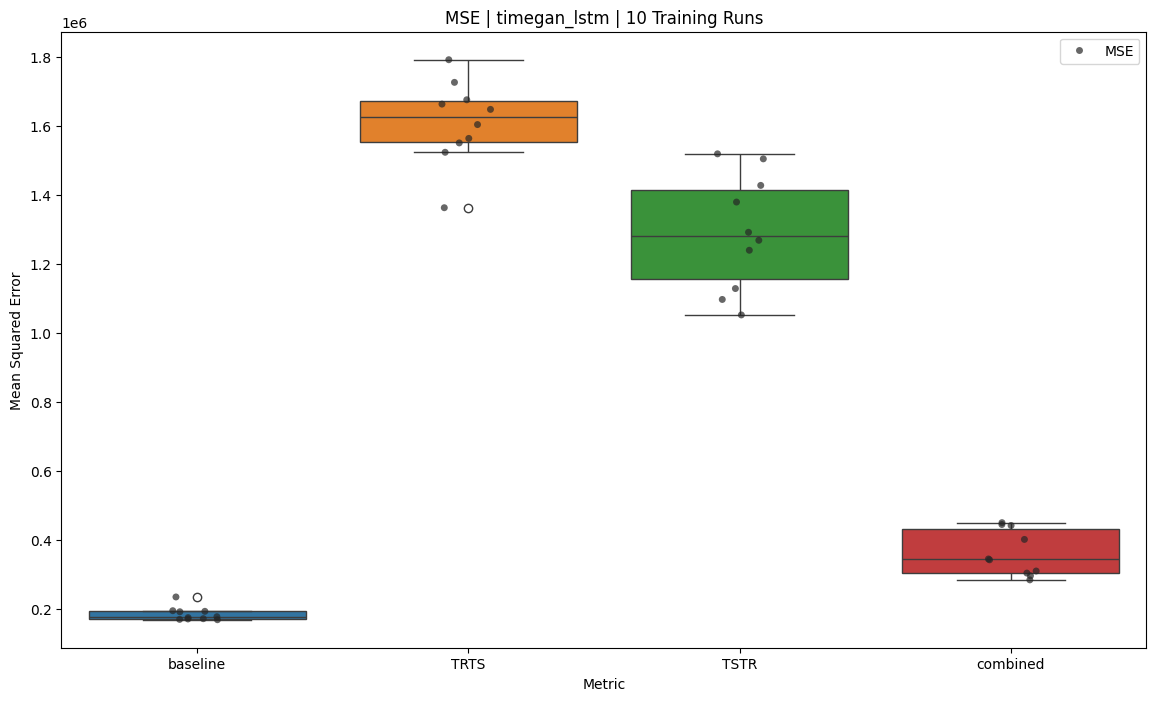

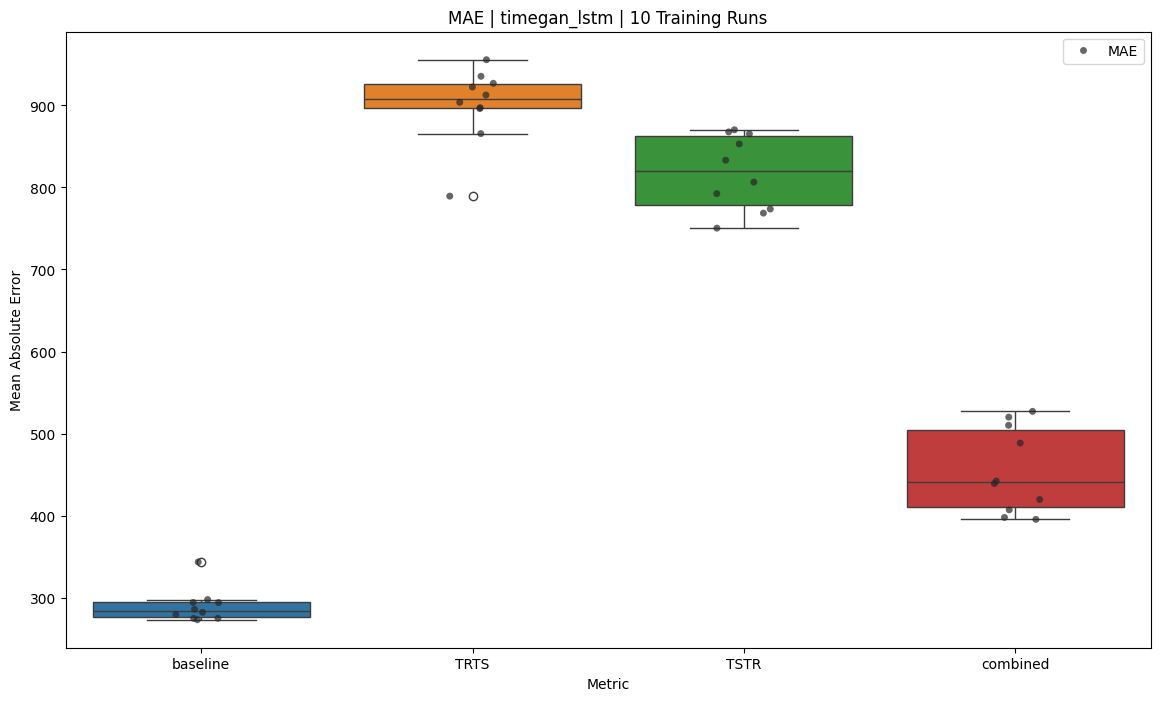

In [8]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

In [9]:
0.2*1e06

200000.0